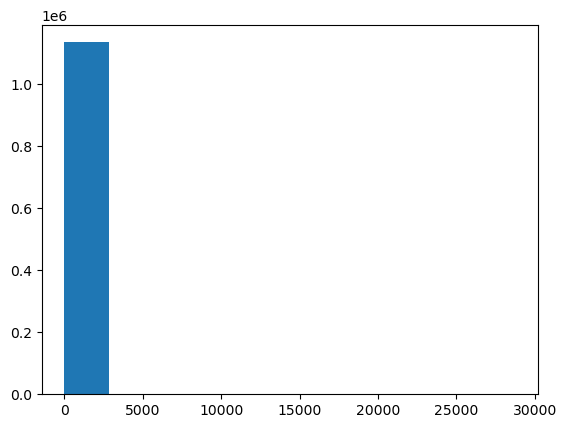

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# 加载数据
G = nx.read_edgelist('../Data_Q7/socialmedia.graph.txt')

# 计算聚类系数
clustering_coefficient = nx.clustering(G)

# 绘制度分布
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees)
plt.show()

In [1]:
import pandas as pd
from neo4j import GraphDatabase
from tqdm import tqdm
from neo4j import GraphDatabase

In [2]:
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__password = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__password))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        session = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            session.run(query, parameters)
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()

def batch_import(df, conn):
    """ 导入单个批次的数据 """
    query = """
    UNWIND $rows AS row
    MERGE (user1:User {id: row[0]})
    MERGE (user2:User {id: row[1]})
    MERGE (user1)-[:FRIEND]->(user2)
    """
    conn.query(query, parameters={'rows': df.values.tolist()})

# 连接到 Neo4j
conn = Neo4jConnection(uri="neo4j://localhost:7687", user="neo4j", pwd="dsaa5002")

# 读取数据文件
file_path = '../Data_Q7/socialmedia.graph.txt'
data = pd.read_csv(file_path, delimiter='\t', skiprows=2, header=None)


In [3]:
# 分批次导入
batch_size = 10000  # 可以根据需要调整批次大小
for start in tqdm(range(0, len(data), batch_size), desc="Importing data"):
    end = start + batch_size
    batch_data = data[start:end]
    batch_import(batch_data, conn)


Importing data:  24%|██▍       | 72/299 [7:43:57<24:22:43, 386.63s/it]


KeyboardInterrupt: 

In [4]:
# 创建图形投影
def create_graph_projection(conn):
    query = """
    CALL gds.graph.project(
        'myGraph',
        'User',
        'FRIEND',
        {
            nodeProperties: 'id',
            relationshipProperties: 'id'
        }
    )
    """
    conn.query(query)

# 计算聚类系数
def calculate_clustering_coefficient(conn):
    query = """
    CALL gds.localClusteringCoefficient.stream('myGraph')
    YIELD nodeId, localClusteringCoefficient
    RETURN avg(localClusteringCoefficient) AS averageClusteringCoefficient
    """
    return conn.query(query)

# 计算度分布
def calculate_degree_distribution(conn):
    query = """
    CALL gds.degree.stream('myGraph')
    YIELD nodeId, score
    RETURN score, count(nodeId) AS numNodes
    ORDER BY score
    """
    return conn.query(query)

In [5]:
# 连接到 Neo4j
conn = Neo4jConnection(uri="neo4j://localhost:7687", user="neo4j", pwd="dsaa5002")

# 创建图形投影
create_graph_projection(conn)

# 计算聚类系数
avg_clustering_coefficient = calculate_clustering_coefficient(conn)
print("Average Clustering Coefficient:", avg_clustering_coefficient)

# 计算度分布并绘制
degree_distribution = calculate_degree_distribution(conn)
degrees, counts = zip(*[(record["score"], record["numNodes"]) for record in degree_distribution])

plt.bar(degrees, counts)
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.title('Degree Distribution')
plt.show()

# 关闭连接
conn.close()

Average Clustering Coefficient: None


TypeError: 'NoneType' object is not iterable